# Mod 4 Project - Starter Notebook




This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!




# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
!pip install -U fsds_100719
from fsds_100719.imports import *

fsds_1007219  v0.6.2 loaded.  Read the docs: https://fsds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds_100719,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


In [2]:
## Import Your Mod 4 Functions
import functions_mod4proj as ji
help(ji)

## Project Notebook Settings
pd.set_option('display.max_columns',0)

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-poster')

Help on module functions_mod4proj:

NAME
    functions_mod4proj

FUNCTIONS
    get_model_metrics(true, preds, train, explain_U=False)
    
    get_train_test_split_index(ts, TEST_SIZE=0.2)
    
    make_dateindex(df_to_add_index, index_col='Month', index_name='date', drop=True, freq=None, verbose=True)
    
    melt_data(df)
    
    meta_grid_search(ts, TEST_SIZE=0.2, model_kws={}, verbose=True, return_kws=False)
    
    plotly_timeseries(df, x='datetime', y='MeanValue', color='RegionID', line_group='State')
    
    stationarity_check(TS, plot=True, col=None)
        From: https://learn.co/tracks/data-science-career-v2/module-4-a-complete-data-science-project-using-multiple-regression/working-with-time-series-data/time-series-decomposition
    
    thiels_U(ys_true=None, ys_pred=None, display_equation=True, display_table=True)
        Calculate's Thiel's U metric for forecasting accuracy.
        Accepts true values and predicted values.
        Returns Thiel's U

FILE
    /Users/ja

In [3]:
df=pd.read_csv('zillow_data.csv')
df.head().style.set_caption("ORIGINAL WIDE FORMAT")

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200,335400,336500,337600,338500,339500,340400,341300,342600,344400,345700,346700,347800,349000,350400,352000,353900,356200,358800,361800,365700,370200,374700,378900,383500,388300,393300,398500,403800,409100,414600,420100,426200,432600,438600,444200,450000,455900,462100,468500,475300,482500,490200,498200,507200,516800,526300,535300,544500,553500,562400,571200,579800,588100,596300,604200,612200,620200,627700,634500,641000,647000,652700,658100,663300,668400,673400,678300,683200,688300,693300,698000,702400,706400,710200,714000,717800,721700,725700,729900,733400,735600,737200,739000,740900,742700,744400,746000,747200,748000,749000,750200,752300,755300,759200,764000,769600,775600,781900,787900,793200,798200,803100,807900,812900,818100,823100,828300,834100,839800,845600,851800,858000,864400,870700,876200,880700,884400,887600,890500,893300,895500,897300,899000,900400,902000,904400,907100,909700,911900,913000,913000,912000,909300,905300,901400,897900,895400,893600,891100,887000,881700,875900,870300,865100,859000,851500,843800,836400,830700,827300,824800,821600,818300,814600,809800,803600,795500,786900,780700,776900,774700,774200,774400,774600,775600,777800,775200,767900,764700,766100,764100,759700,754900,746200,737300,730800,729300,730200,730700,730000,730100,730100,731200,733900,735500,735400,734400,737500,737700,733700,734000,740300,744600,750500,760400,771800,780600,787900,794100,798900,802300,806100,810900,817400,826800,837900,848100,853800,856700,856600,854400,853000,856200,859700,863900,872900,883300,889500,892800,893600,891300,889900,891500,893000,893000,895000,901200,909400,915000,916700,917700,919800,925800,937100,948200,951000,952500,958600,966200,970400,973900,974700,972600,974300,980800,988000,994700,998700,997000,993700,991300,989200,991300,9991

In [4]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 'CountyName', 
                                  'SizeRank'], var_name='Month', value_name='MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format='%Y-%m')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

In [5]:
df = melt_data(df)
df.head().style.set_caption("MELTED LONG FORMAT")

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Month,MeanValue
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01 00:00:00,334200
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01 00:00:00,235700
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01 00:00:00,210400
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01 00:00:00,498100
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01 00:00:00,77300


# Step 2: Preprocessing

In [6]:
# fs.ihelp(ji.make_dateindex)

In [7]:

def make_dateindex(df_to_add_index, index_col='Month',
                   index_name = 'date', drop=True, verbose=True):
    """Converts the specified index_col to a datetime index 
    with name=index_name.
    """

    ## Copy intput df and reset index
    df = df_to_add_index.copy()
    df.reset_index(drop=True)

    ## Make datetime column (to make into index)
    df[index_name] = pd.to_datetime(df[index_col], errors='coerce')
    
    ## Set index
    df = df.set_index(index_name,drop=drop)

    if verbose:
        display(df.index)

    return df

df = ji.make_dateindex(df,index_col='Month',index_name='date')
df

DatetimeIndex(['1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01',
               ...
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01'],
              dtype='datetime64[ns]', name='date', length=3744704, freq=None)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Month,MeanValue
date,,,,,,,,,
1996-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1996-04-01,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
1996-04-01,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
1996-04-01,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
1996-04-01,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0
...,...,...,...,...,...,...,...,...,...
2018-04-01,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,2018-04-01,209300.0
2018-04-01,59107,3293,Woodstock,NH,Claremont,Grafton,14720,2018-04-01,225800.0
2018-04-01,75672,40404,Berea,KY,Richmond,Madison,14721,2018-04-01,133400.0


## Resampling Data

In [8]:
# df.loc[df['RegionName']==12211]

In [9]:
df2 = df.groupby('RegionName').resample(rule='MS').asfreq('MS')
df2.head()

RegionID  RegionName  ...      Month MeanValue
RegionName date                              ...                     
1001       1996-04-01     58196        1001  ... 1996-04-01  113100.0
           1996-05-01     58196        1001  ... 1996-05-01  112800.0
           1996-06-01     58196        1001  ... 1996-06-01  112600.0
           1996-07-01     58196        1001  ... 1996-07-01  112300.0
           1996-08-01     58196        1001  ... 1996-08-01  112100.0

[5 rows x 9 columns]

In [10]:
df2.isna().sum()

RegionID           0
RegionName         0
City               0
State              0
Metro         236023
CountyName         0
SizeRank           0
Month              0
MeanValue          0
dtype: int64

In [11]:
df2['Metro'].fillna('missing',inplace=True)
df2

RegionID  RegionName  ...      Month MeanValue
RegionName date                              ...                     
1001       1996-04-01     58196        1001  ... 1996-04-01  113100.0
           1996-05-01     58196        1001  ... 1996-05-01  112800.0
           1996-06-01     58196        1001  ... 1996-06-01  112600.0
           1996-07-01     58196        1001  ... 1996-07-01  112300.0
           1996-08-01     58196        1001  ... 1996-08-01  112100.0
...                         ...         ...  ...        ...       ...
99901      2017-12-01    100478       99901  ... 2017-12-01  291900.0
           2018-01-01    100478       99901  ... 2018-01-01  294200.0
           2018-02-01    100478       99901  ... 2018-02-01  297500.0
           2018-03-01    100478       99901  ... 2018-03-01  302100.0
           2018-04-01    100478       99901  ... 2018-04-01  305100.0

[3744704 rows x 9 columns]

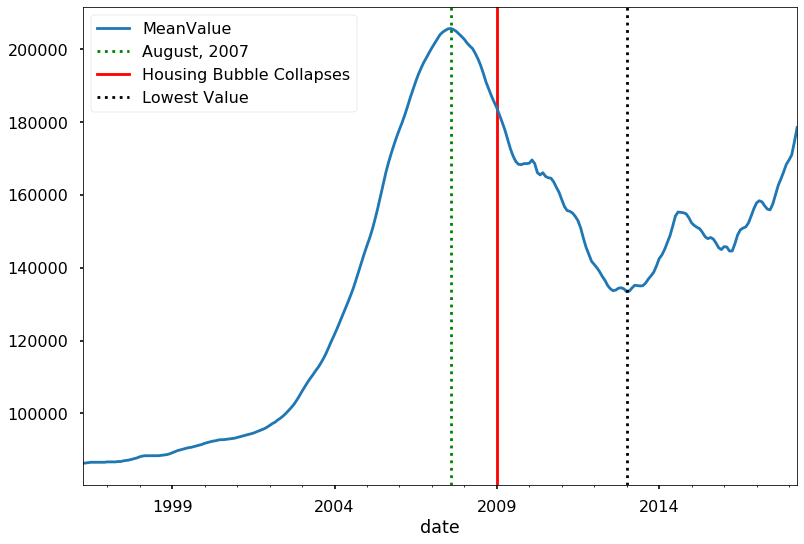

In [12]:
## Getting single zipcode
ts = df2["MeanValue"].loc[21207]#12211]

## Plot Value for Full Timeperiod
ax = ts.plot()

## Find maximum value before the housing bubble collapsed
max_ = ts.loc['2004':'2010'].idxmax()
crash = '01-2009'

ax.axvline(max_,
           **{'label':max_.strftime('%B, %Y'),
              'c':'green','ls':':'})
## label month after crash https://en.wikipedia.org/wiki/United_States_housing_bubble
ax.axvline(crash,label='Housing Bubble Collapses',
          c='red',zorder=0)

## Label lowest point for zipcode since housing crash
min_ = ts.loc[crash:].idxmin()
min_val = ts.loc[min_]

ax.axvline(min_,label='Lowest Value', ls=':',c='black',ymin=0,ymax=min_val)
ax.legend()


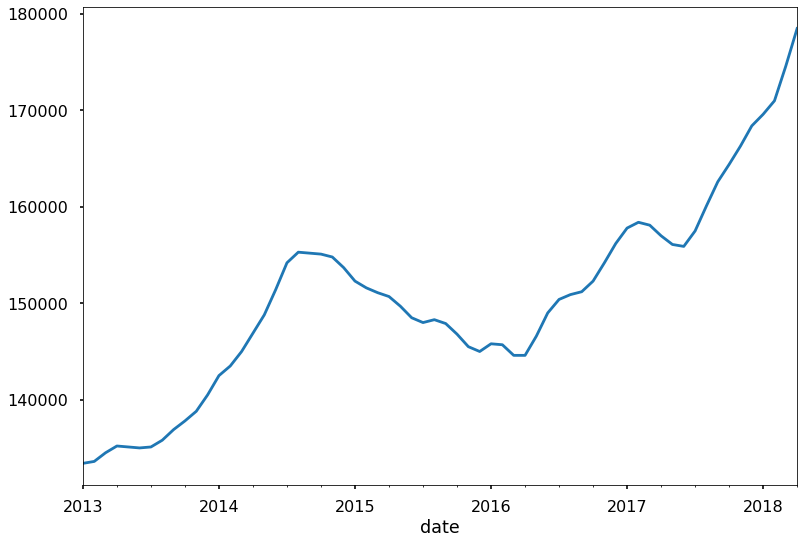

In [13]:
ts = ts.loc[min_:]
ts.plot()

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='date', length=265, freq='MS')


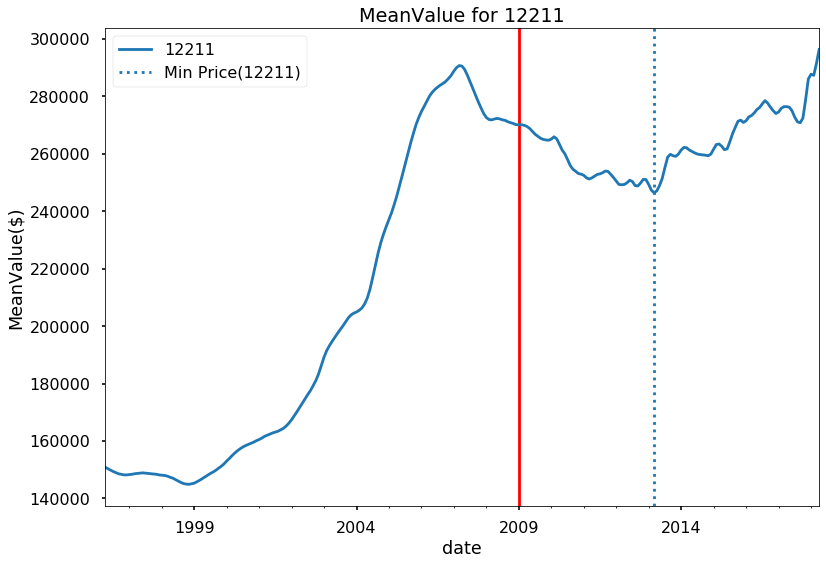

In [14]:
def plot_zipcode_min_max(df,col='MeanValue',zipcode=12211,freq='MS',
                        label_crash=False):
    
    ## Getting single zipcode
    ts = df2[col].loc[zipcode].rename(str(zipcode))#12211]
    ts = ts.resample(rule=freq).asfreq()
#     ts_index = ts.index.to_series().astype('O')
#     ts_index = pd.to_datetime(ts_index)
    print(ts.index)

    ## Plot Value for Full Timeperiod
#     fig,ax =plt.subplots()
    ax = ts.plot()
    #     ax.plot(ts_index,ts)
    lines = ax.get_lines()
    linecolor = lines[-1].get_color()

    ## Find maximum value before the housing bubble collapsed
    max_ = ts.loc['2004':'2010'].idxmax()
    crash = '01-2009'

    ## Plot Max Value before crash
#     ax.axvline(max_,
#                **{'label':max_.strftime('%B, %Y'),
#                   'c':'green','ls':':'})
    
    ## label month after crash https://en.wikipedia.org/wiki/United_States_housing_bubble
    ax.axvline(crash,#label='Housing Bubble Collapses',
              c='red',zorder=0)

    ## Label lowest point for zipcode since housing crash
    min_ = ts.loc[crash:].idxmin()
    min_val = ts.loc[min_]
    
    ax.axvline(min_,label=f'Min Price({zipcode})', 
               ls=':',c=linecolor,ymin=0,ymax=min_val)
    
    ax.set(title=f"{col} for {zipcode}",
          ylabel =f"{col}($)")
    
    if label_crash:
        ax.text(x='01-2009', y=ax.get_ylim()[0]+2000,
                s='Housing Bubble pops', fontdict={
                    'rotation':90,'ha':'left', 'size':12,'color':'black',
                     'clip_on':True,'backgroundcolor':'red'
                },alpha=0.6)
    ax.legend()

#     ## FORMAT DATE AXIS
#     months = mpl.dates.MonthLocator()
#     monthsFmt = mpl.dates.DateFormatter('%b')
    
#     years = mpl.dates.YearLocator()
#     yearsFmt = mpl.dates.DateFormatter('%Y')
    
#     ax.xaxis.set_minor_locator(months)
#     ax.xaxis.set_minor_formatter(monthsFmt)
    
#     ax.xaxis.set_major_locator(years)
#     ax.xaxis.set_major_formatter(yearsFmt)
#     ax.xaxis.grid(True,'minor',c='gray',ls=':')
#     ax.xaxis.grid(True,'major',c='black',lw=3)
    return ts,ax
ts1,ax = plot_zipcode_min_max(df2,zipcode=12211)

In [15]:
fig = ax.get_figure()
fig
lines = ax.get_lines()
lines[0].get_color()

'#1f77b4'

In [16]:
# ax.text(x='01-2009',y=150000,s='Housing Bubble pops',
#        fontdict={'rotation':90, 'size':12,
#                  'color':'black',
#                  'clip_on':True,'backgroundcolor':'red'},alpha=0.6)
# fig=ax.get_figure()
# fig

In [17]:
np.mean(ax.get_ylim())

220600.0

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='date', length=265, freq='MS')
DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='date', length=265, freq='MS')


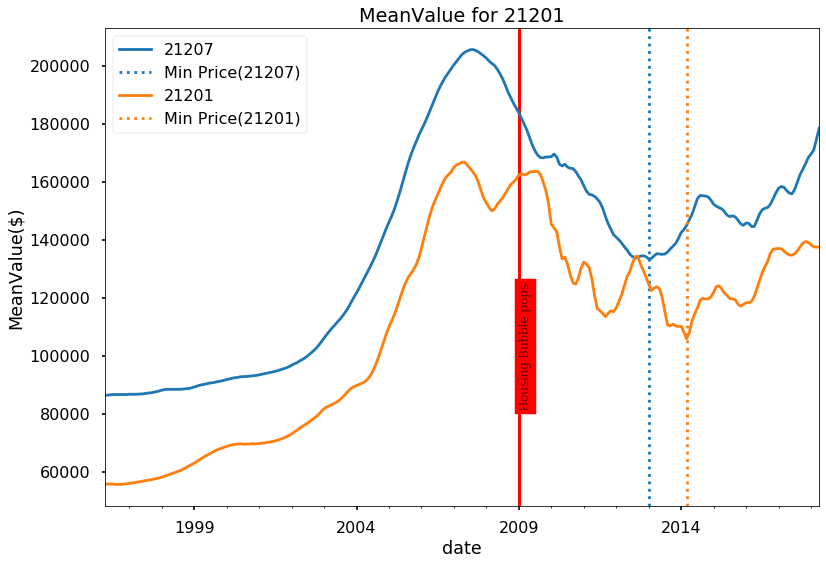

In [18]:
ts2 = plot_zipcode_min_max(df,zipcode=21207,label_crash=True)
ts2 = plot_zipcode_min_max(df,zipcode=21201)

### Notes on Time Period 
- For 12211: ~2014:end

### Time Period = 2014:

In [19]:
df2.index

MultiIndex([( 1001, '1996-04-01'),
            ( 1001, '1996-05-01'),
            ( 1001, '1996-06-01'),
            ( 1001, '1996-07-01'),
            ( 1001, '1996-08-01'),
            ( 1001, '1996-09-01'),
            ( 1001, '1996-10-01'),
            ( 1001, '1996-11-01'),
            ( 1001, '1996-12-01'),
            ( 1001, '1997-01-01'),
            ...
            (99901, '2017-07-01'),
            (99901, '2017-08-01'),
            (99901, '2017-09-01'),
            (99901, '2017-10-01'),
            (99901, '2017-11-01'),
            (99901, '2017-12-01'),
            (99901, '2018-01-01'),
            (99901, '2018-02-01'),
            (99901, '2018-03-01'),
            (99901, '2018-04-01')],
           names=['RegionName', 'date'], length=3744704)

In [20]:
## LIMITING INDEX TO 2014 and on
try:
    df = df2.loc[pd.IndexSlice[:,'2014-01-01':],:].copy()
    df.to_csv('zillow_post_2014.csv')
    del df2
except:
    print('Could not delete df2')
df

RegionID  RegionName  ...      Month MeanValue
RegionName date                              ...                     
1001       2014-01-01     58196        1001  ... 2014-01-01  185100.0
           2014-02-01     58196        1001  ... 2014-02-01  184800.0
           2014-03-01     58196        1001  ... 2014-03-01  184900.0
           2014-04-01     58196        1001  ... 2014-04-01  184500.0
           2014-05-01     58196        1001  ... 2014-05-01  184500.0
...                         ...         ...  ...        ...       ...
99901      2017-12-01    100478       99901  ... 2017-12-01  291900.0
           2018-01-01    100478       99901  ... 2018-01-01  294200.0
           2018-02-01    100478       99901  ... 2018-02-01  297500.0
           2018-03-01    100478       99901  ... 2018-03-01  302100.0
           2018-04-01    100478       99901  ... 2018-04-01  305100.0

[765260 rows x 9 columns]

## Picking Sub-Set of Data (MD)

In [21]:
state='MD'
md = df.loc[df['State']=='MD'].copy()
print(md.RegionName.nunique(),' # of zipcodes.')
print(md.City.nunique(),' # of Cities.')
print(md.Metro.nunique(),' # of Metros.')
print(md.CountyName.nunique(),' # of Counties.')
md

317  # of zipcodes.
264  # of Cities.
10  # of Metros.
23  # of Counties.


RegionID  RegionName  ...      Month MeanValue
RegionName date                              ...                     
20601      2014-01-01     66494       20601  ... 2014-01-01  236000.0
           2014-02-01     66494       20601  ... 2014-02-01  236400.0
           2014-03-01     66494       20601  ... 2014-03-01  237500.0
           2014-04-01     66494       20601  ... 2014-04-01  239600.0
           2014-05-01     66494       20601  ... 2014-05-01  241100.0
...                         ...         ...  ...        ...       ...
21921      2017-12-01     67111       21921  ... 2017-12-01  212800.0
           2018-01-01     67111       21921  ... 2018-01-01  213300.0
           2018-02-01     67111       21921  ... 2018-02-01  214700.0
           2018-03-01     67111       21921  ... 2018-03-01  217000.0
           2018-04-01     67111       21921  ... 2018-04-01  219000.0

[16484 rows x 9 columns]

In [22]:
md['CountyName'].value_counts(normalize=True)

Montgomery        0.116719
Prince Georges    0.107256
Baltimore         0.097792
Anne Arundel      0.085174
Frederick         0.066246
Howard            0.053628
Harford           0.053628
Charles           0.047319
Baltimore City    0.044164
Calvert           0.034700
Saint Marys       0.031546
Wicomico          0.028391
Washington        0.028391
Carroll           0.028391
Cecil             0.025237
Allegany          0.025237
Talbot            0.022082
Queen Annes       0.022082
Kent              0.018927
Garrett           0.018927
Worcester         0.015773
Caroline          0.015773
Dorchester        0.012618
Name: CountyName, dtype: float64

In [23]:
balt_city = md.loc[md['CountyName']=='Baltimore City']
balt_cnty = md.loc[md['CountyName']=='Baltimore']
display(balt_cnty.head(),balt_city.head())

RegionID  RegionName  ...      Month MeanValue
RegionName date                              ...                     
21013      2014-01-01     66723       21013  ... 2014-01-01  385900.0
           2014-02-01     66723       21013  ... 2014-02-01  383600.0
           2014-03-01     66723       21013  ... 2014-03-01  385300.0
           2014-04-01     66723       21013  ... 2014-04-01  387000.0
           2014-05-01     66723       21013  ... 2014-05-01  387500.0

[5 rows x 9 columns]

RegionID  RegionName  ...      Month MeanValue
RegionName date                              ...                     
21201      2014-01-01     66811       21201  ... 2014-01-01  110200.0
           2014-02-01     66811       21201  ... 2014-02-01  108100.0
           2014-03-01     66811       21201  ... 2014-03-01  105900.0
           2014-04-01     66811       21201  ... 2014-04-01  107900.0
           2014-05-01     66811       21201  ... 2014-05-01  112000.0

[5 rows x 9 columns]

In [24]:
md.reset_index(inplace=True,level=0,drop=True)
# md.set_index('date',inplace=True)
ts21201 = md.loc[md['RegionName']==21201]["MeanValue"].rename(21201)
ts21207 = md.loc[md['RegionName']==21207]["MeanValue"].rename(21207)
display(ts21201.head(),ts21207.tail())

date
2014-01-01    110200.0
2014-02-01    108100.0
2014-03-01    105900.0
2014-04-01    107900.0
2014-05-01    112000.0
Name: 21201, dtype: float64

date
2017-12-01    168400.0
2018-01-01    169600.0
2018-02-01    171000.0
2018-03-01    174600.0
2018-04-01    178500.0
Name: 21207, dtype: float64

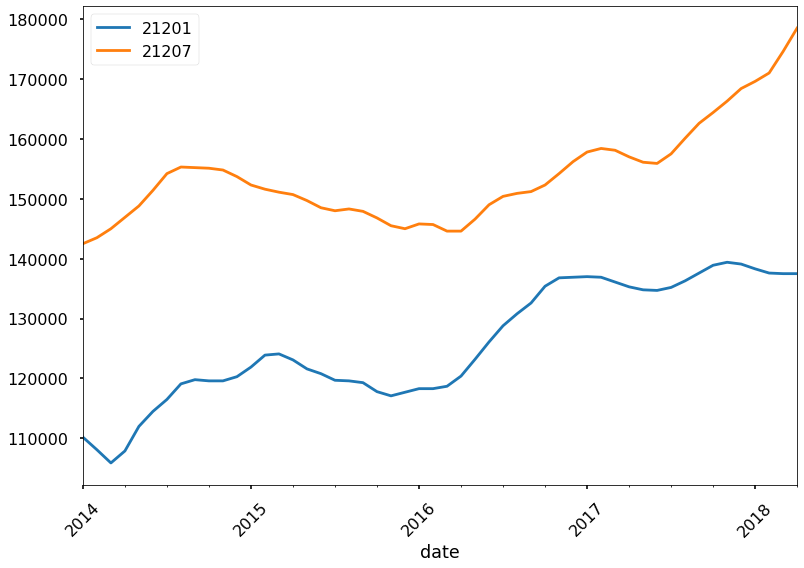

In [25]:
ax = ts21201.plot(rot=45)
ts21207.plot(rot=45)
ax.legend()

# Step 3: EDA and Visualization

## ESTIMATING AR(p),  MA(q) VISUALLY

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
from  statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.plotting import autocorrelation_plot,lag_plot

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}

mpl.rc('font', **font)

# # NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [27]:
def plot_acf_pacf(ts,figsize=(10,6),lags=15):
    title = f"ZIPCODE={ts.name}"
    fig,ax =plt.subplots(nrows=2,figsize=figsize,sharex=True)
    fig.suptitle(title,y=1.02)
    
    plot_acf(ts,ax=ax[0],lags=lags,title='');
    ax[0].set_ylabel('Autocorrelation')
    plot_pacf(ts,ax=ax[1],lags=lags,title='');
    ax[1].set_ylabel('Partial Autocorrelation')    
    
    for a in ax:
        a.xaxis.set_major_locator(mpl.ticker.MaxNLocator(min_n_ticks=lags, integer=True))
        a.xaxis.grid()
        
#         a.xaxis.set_minor_locator(mpl.ticker.LinearLocator(numticks=lags))
#         a.xaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
#         a.xaxis.grid(which='both')
#         a.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useOffset=True))

    plt.tight_layout()                                  
    return fig,ax
 

- In an ARMA model, is a regression on paste values (AR part) and the error term is modeled as a linear combo of error terms in the recent past (MA part). 
- Notation is generally ARMA(p,q)
    - Example: ARMA(2,1) model equation
     $$Y_t = \mu + \phi_1 Y_{t-1}+\phi_2 Y_{t-2}+ \theta \epsilon_{t-1}+\epsilon_t$$
     
- AR(p):
    - ACF for AR(p) would be strong until lag of p, then stagnant, then trail off. 
    - PACF for AR(p): Generally no correlation for lag values beyond p.
- MA(q):
    - ACF for MA(q) would show strong correlation up to a lag of q, the immedately decline to minimal/no correction.
    - PACF would show strong relationship to the lab and tailing off to no correlation afterwards.
    
    


|PLOT | AR(p)   |   MA(q)  | ARMA(p,q)|
|--- |--- |--- |--- |
| ACF | Tails off   |  Cuts off after lag q |  Tails off   |
|PACF | Cuts off after lag p  |   Tails off  |  Tails off  |

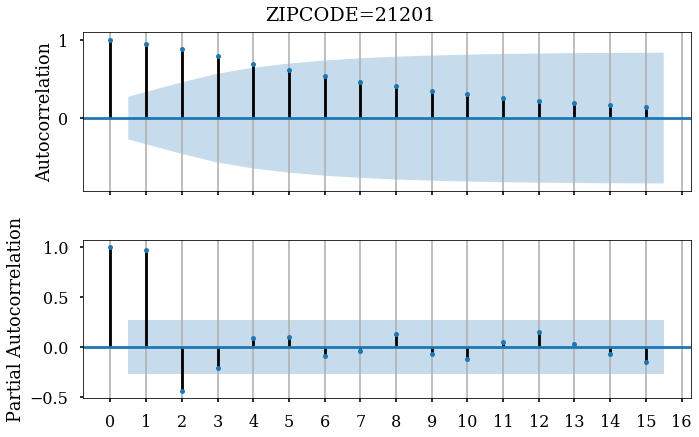

In [28]:
f,a = plot_acf_pacf(ts21201)

### INTERPRETATON:
## ACF: 
# p=2-4
# q= ..? Doesn't cut off

## PACF: 
# p=2
# q= 2? Doesn't "tail off"

# Step 5: ARIMA Modeling

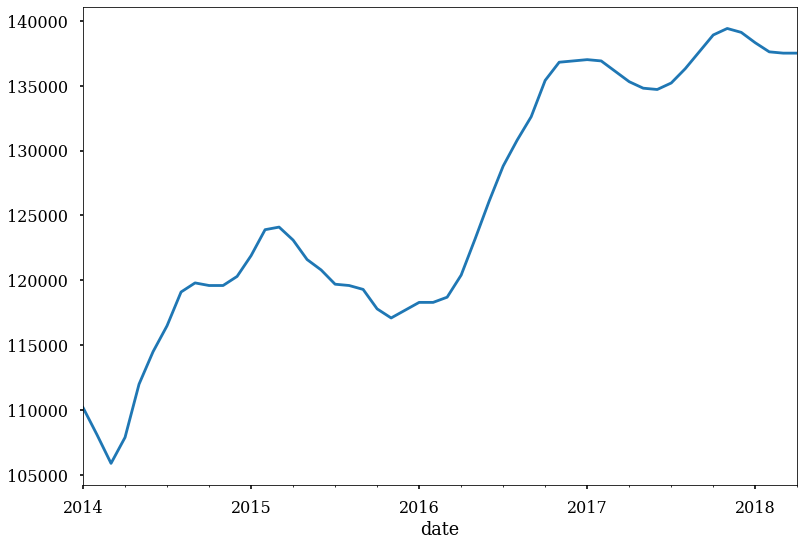

In [29]:
ts21201.plot()

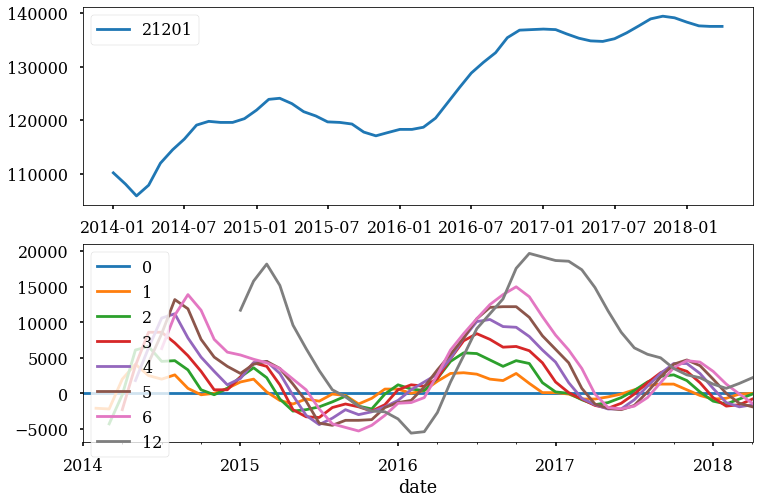

In [30]:
# i = 1
# ax = ts21201.plot()
fig,ax=plt.subplots(2,1,figsize=(12,8))#,sharex=True)
ax[0].plot(ts21201,label=ts21201.name)
for i in [0,1,2,3,4,5,6,12]:#range(1,7):
    ts21201.diff(i).plot(label=i,ax=ax[1])
[a.legend() for a in ax]

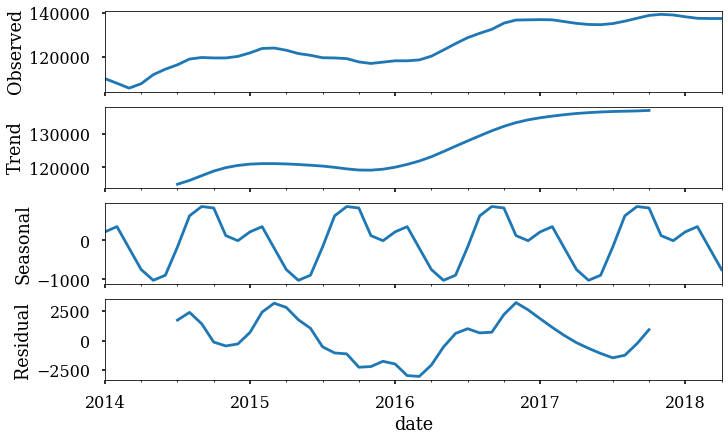

In [31]:
decomp = seasonal_decompose(ts21201,model='add')
fig= decomp.plot()
# fig = ax.get_figure()
fig.set_size_inches(10,6)


365 days 00:00:00


Text(0.5, 1.0, 'Season Length = 365 days 00:00:00')

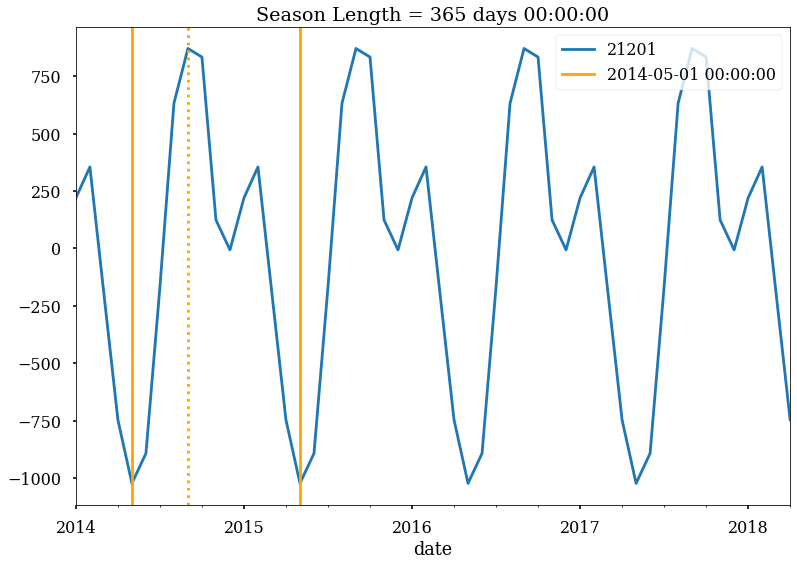

In [32]:
ts_seas = decomp.seasonal
ax = decomp.seasonal.plot()
fig=ax.get_figure()


## Get min and max idx
min_ = ts_seas.idxmin()
max_ = ts_seas.idxmax()

min_2 = ts_seas.loc[max_:].idxmin()

# ax.fill_betweenx(y=1,x1=min_,x2=max_)
ax.axvline(min_,label=min_,c='orange')
ax.axvline(max_,c='orange',ls=':')
ax.axvline(min_2,c='orange')
ax.legend()
## Calculate season size
period = min_2 - min_#ts_seas.idxmax()-ts_seas.idxmin()
print(period)
# print(max_)
# print(min_)
# fig
ax.set_title(f'Season Length = {period}')

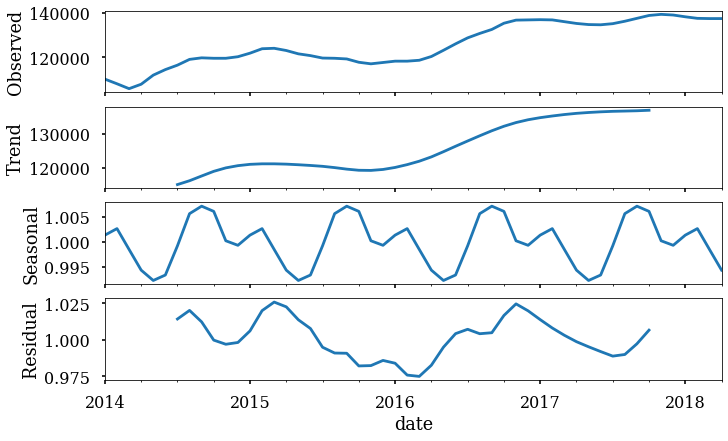

In [33]:
decomp = seasonal_decompose(ts21201,model='mul')
fig= decomp.plot()
# fig = ax.get_figure()
fig.set_size_inches(10,6)

In [34]:
## Generate model orders
p_range=range(0,4)
q_range = range(0,3)
d_range = range(0,2)
m_range = (0,3,4,6)#,8)
p_range,q_range,d_range,m_range

(range(0, 4), range(0, 3), range(0, 2), (0, 3, 4, 6))

In [35]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [36]:
pdq = list(itertools.product(p_range,d_range,q_range))
pdqm = list(itertools.product(p_range,d_range,q_range,m_range))
pdqm[0]

(0, 0, 0, 0)

In [37]:
def make_pdq_pdqm(p_range=(0,4),d_range=(0,2), 
                  q_range=(0,3),make_seasonal=True,
                  m_values=(0,3,4,6,12)):
    import itertools
    ps =range(p_range[0],p_range[1])
    ds =range(d_range[0],d_range[1])
    qs =range(q_range[0],q_range[1])
    
    params = {}
    params['pdq'] = list(itertools.product(ps,ds,qs))
    
    if make_seasonal:
        params['PDQm'] = list(itertools.product(ps,ds,qs,m_values))
    return params
#     ps =range(p_range[0],p_range[1])
order_dict = make_pdq_pdqm()
order_dict

{'pdq': [(0, 0, 0),
  (0, 0, 1),
  (0, 0, 2),
  (0, 1, 0),
  (0, 1, 1),
  (0, 1, 2),
  (1, 0, 0),
  (1, 0, 1),
  (1, 0, 2),
  (1, 1, 0),
  (1, 1, 1),
  (1, 1, 2),
  (2, 0, 0),
  (2, 0, 1),
  (2, 0, 2),
  (2, 1, 0),
  (2, 1, 1),
  (2, 1, 2),
  (3, 0, 0),
  (3, 0, 1),
  (3, 0, 2),
  (3, 1, 0),
  (3, 1, 1),
  (3, 1, 2)],
 'PDQm': [(0, 0, 0, 0),
  (0, 0, 0, 3),
  (0, 0, 0, 4),
  (0, 0, 0, 6),
  (0, 0, 0, 12),
  (0, 0, 1, 0),
  (0, 0, 1, 3),
  (0, 0, 1, 4),
  (0, 0, 1, 6),
  (0, 0, 1, 12),
  (0, 0, 2, 0),
  (0, 0, 2, 3),
  (0, 0, 2, 4),
  (0, 0, 2, 6),
  (0, 0, 2, 12),
  (0, 1, 0, 0),
  (0, 1, 0, 3),
  (0, 1, 0, 4),
  (0, 1, 0, 6),
  (0, 1, 0, 12),
  (0, 1, 1, 0),
  (0, 1, 1, 3),
  (0, 1, 1, 4),
  (0, 1, 1, 6),
  (0, 1, 1, 12),
  (0, 1, 2, 0),
  (0, 1, 2, 3),
  (0, 1, 2, 4),
  (0, 1, 2, 6),
  (0, 1, 2, 12),
  (1, 0, 0, 0),
  (1, 0, 0, 3),
  (1, 0, 0, 4),
  (1, 0, 0, 6),
  (1, 0, 0, 12),
  (1, 0, 1, 0),
  (1, 0, 1, 3),
  (1, 0, 1, 4),
  (1, 0, 1, 6),
  (1, 0, 1, 12),
  (1, 0, 2, 0),
  (1, 0,

## TRAIN TEST SPLIT

In [38]:
len(ts)

64

In [39]:
# fs.ihelp(ji.get_train_test_split_index,0)
def get_train_test_split_index(ts, TEST_SIZE=0.1,min_test_ts=2):
    import math
    idx_split = math.floor(len(ts.index)*(1-TEST_SIZE))
    
    num_test_ts=len(ts.iloc[idx_split:])
    if num_test_ts<min_test_ts:
        print(f'[!] Warning: using TEST_SIZE={TEST_SIZE} produced {num_test_ts} test timestamps.')
        print("- Overriding TEST_SIZE and using min_test_ts instead.")
        idx_split = len(ts)-min_test_ts
    
    return idx_split

def train_test_split_ts(ts,TEST_SIZE=0.2,min_test_ts=2):
    idx_split = get_train_test_split_index(ts,TEST_SIZE=TEST_SIZE,
                                           min_test_ts=min_test_ts)
    ts_train = ts.iloc[:idx_split]
    ts_test = ts.iloc[idx_split:]
    return ts_train, ts_test


ts_train, ts_test = train_test_split_ts(ts)
print(len(ts_train),len(ts_test))


51 13


In [40]:
# import math
# idx_split = math.floor(len(ts21201.index)*(1-0.20))
# idx_split

In [41]:
# ts = ts21201.copy()
# idx_split = get_train_test_split_index(ts,TEST_SIZE=0.1)
# ts_train = ts.iloc[:idx_split]
# ts_test = ts.iloc[idx_split:]

# len(ts_train),len(ts_test)

## GRID SEARCH

In [42]:
import tqdm
from tqdm import trange


def get_now(return_dt = True, return_str=True, show=False):
    import datetime as dt
    import tzlocal as tz
    now=dt.datetime.now(tz=tz.get_localzone())
    str_time =now.strftime('%m/%d/%Y - %I:%M:%S %p')
    if show:
        print(str_time)
    
    output=[]
    if return_dt:
        output.append(now)
        
    if return_str:
        output.append(str_time)
    return output[:]


def grid_search_sarimax(ts_train,pdq=None,pdqm=None,order_dict=None,
                        verbose=False):

    from tqdm import trange
    
    if (pdq is None) & (order_dict is not None):
        pdq= order_dict['pdq']
    if (pdqm is None) & (order_dict is not None):
        pdqm= order_dict['PDQm']
    start,start_str = get_now(return_dt=True,return_str=True)
    print(f'[i] STARTING GRID SEARCH @ {start_str}:')
    
    
    res = [['pdq','PDQm','AIC']]
    for i in trange(len(pdq)):
        comb = pdq[i]

        for combs in pdqm:
            try:
                model = SARIMAX(ts_train,order=comb, 
                                seasonal_order=combs,
                                enforce_invertibility=False,
                                enforce_stationarity=False)
                output=model.fit()
                res.append([comb,combs,output.aic])
            except:
                if verbose:
                    print(f"[!] Error running ({comb})({combs})")
                continue
                
    end,end_str =get_now(return_dt=True,return_str=True)
    
    elapsed = end-start
    print(f"[o]: GRID SEARCHED FINISHED @ {end_str}")
    print(f"\tTotal Time: {elapsed} secs.")
    
    
                
    try:
        df_res = fs.list2df(res)
        return df_res
    except:
        print('Error converting to df. Returning as list.')
        return res


In [43]:
res = grid_search_sarimax(ts_train,order_dict=order_dict)#pdq,pdqm)

  0%|          | 0/24 [00:00<?, ?it/s]

[i] STARTING GRID SEARCH @ 01/01/2020 - 08:56:04 PM:


100%|██████████| 24/24 [06:18<00:00, 15.77s/it]

[o]: GRID SEARCHED FINISHED @ 01/01/2020 - 09:02:22 PM
	Total Time: 0:06:18.362462 secs.


In [44]:
top_params = res.sort_values('AIC').head(10)
display(top_params)
top_params=top_params.loc[top_params['AIC']>0]

best_params =  dict(order=top_params.iloc[0].loc['pdq'],
             seasonal_order = top_params.iloc[0].loc['PDQm']) 
# pd.DataFrame.from_dict(best_params)
best_params

,pdq,PDQm,AIC
92,"(0, 0, 0)","(3, 1, 0, 12)",-55.563922
96,"(0, 0, 0)","(3, 1, 1, 12)",-53.563922
392,"(0, 1, 0)","(3, 1, 0, 12)",-35.771362
396,"(0, 1, 0)","(3, 1, 1, 12)",-33.771362
992,"(1, 1, 0)","(3, 1, 0, 12)",10.462126
1592,"(2, 1, 0)","(3, 1, 0, 12)",12.000000
1892,"(3, 0, 0)","(3, 1, 0, 12)",14.000000
1596,"(2, 1, 0)","(3, 1, 1, 12)",14.000000
2192,"(3, 1, 0)","(3, 1, 0, 12)",14.000000
1692,"(2, 1, 1)","(3, 1, 0, 12)",14.000000


{'order': (1, 1, 0), 'seasonal_order': (3, 1, 0, 12)}

In [45]:
model_output = SARIMAX(ts_train,**best_params).fit()

In [51]:
def get_preds(model_output,ts_train=None,ts_test=None,show_results=True):
    output=model_output
    
    from sklearn.metrics import r2_score,mean_squared_error
    metrics = {'preds':{},'r2':{},'rmse':{},"Thiel's U":{}}
    
    if ts_train is not None:
        y_hat_train = output.predict(start=ts_train.index[0],end=ts_train.index[-1])
        metrics['preds']['train'] = y_hat_train

        metrics['r2']['train'] =r2_score(ts_train, y_hat_train)
        metrics['rmse']['train'] = np.sqrt(mean_squared_error(ts_train,y_hat_train))
        metrics["Thiel's U"]['train'] = ji.thiels_U(ts_train,y_hat_train,
                                                    display_equation=False,
                                                   display_table=False)
        
    if ts_test is not None:

        y_hat_test = output.predict(start=ts_test.index[0],end=ts_test.index[-1])
        metrics['preds']['test'] = y_hat_test

        metrics['r2']['test'] =r2_score(ts_test, y_hat_test)
        metrics['rmse']['test'] = np.sqrt(mean_squared_error(ts_test,y_hat_test))
        metrics["Thiel's U"]['test'] = ji.thiels_U(ts_test,y_hat_test, 
                                                   display_equation=False,
                                                   display_table=False)

    if show_results: 
        show_res = {}
        for k,v in metrics.items():
            if k=='preds':
                continue
            else:
                show_res[k]={}
                for k2,v2 in v.items():
                    show_res[k][k2]=v2
                    
        df_metrics = pd.DataFrame(show_res)
        display(df_metrics)
        
        plt.plot(ts_train,label='Training Data')
        plt.plot(ts_test,label='Test Data')
        plt.plot(y_hat_test,label='Model Forecast')
        plt.legend()
        plt.show()
        
    return metrics

,r2,rmse,Thiel's U
train,-10.199472,23998.932609,13.092707
test,0.689843,3957.725622,1.914355


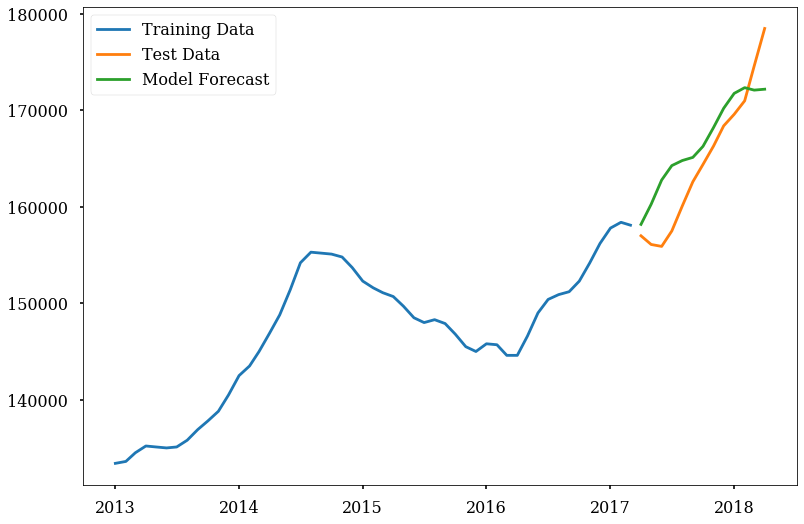

In [46]:
pred_d = get_preds(model_output,ts_train,ts_test)

In [47]:
# pd.DataFrame(pred_d['preds']).plot()

In [58]:
### DIVIDE THESE INTO SEPARATE FUNCTIONS
def get_model_preds(model_output,ts_train=None,ts_test=None,
                   calc_metrics=False,n_periods_pmd=10):
    """Gets the predicted values for ts_train and/or ts_test. Results 
    returned as a dictionary with keys =['train','test']. Changes predict
    method for a `pmdarima.arima.auto.AutoARIMA`for compatibility. 
    
    """
    import pmdarima as pm
    output=model_output
    preds = {}
        
    def select_preds(output,ts):
        if isinstance(output,pm.arima.auto.AutoARIMA):
            print(f'[i] pmdarima AutoARIMA detected. Preds created with n_periods_pmd={n_periods_pmd} instead of ts index dates.')
            ts_pred = output.predict(n_periods=n_periods_pmd)
            if len(ts)!=len(ts_pred):
                print(f'[!] Length ts={len(ts)}. Length ts_pred={len(ts_pred)}/')
#                 raise Exception('Length of preds does not match length of ts.')
        else:
            ts_pred = output.predict(start=ts.index[0],end=ts.index[-1])
        return ts_pred
    
    if ts_train is not None:
        try:
            preds['train'] =select_preds(output,ts_train)
        except Exception as e:
            print(e)
            preds['train'] = [np.nan for x in range(len(ts_train))]
            

        
    if ts_test is not None:
        preds['test'] = select_preds(output,ts_test)#y_hat_test
                
    if calc_metrics:
        preds['metrics']={}
        preds['metrics']['train'] = calc_model_metrics(ts_train, preds['train'])
        preds['metrics']['test'] = calc_model_metrics(ts_test, preds['test'])
    return preds

def calc_model_metrics(ts_true, ts_pred,show_metrics=False):
        from sklearn.metrics import r2_score,mean_squared_error
        metrics = {'r2':None, 'rmse':None,'thiels_u':None}
        
        if len(ts_true)!=len(ts_pred):
            return metrics
        
        metrics['r2'] =r2_score(ts_true, ts_pred)
        metrics['rmse'] = np.sqrt(mean_squared_error(ts_true,ts_pred))
        metrics["Thiel's U"] = ji.thiels_U(ts_true,ts_pred, 
                                                    display_equation=False,
                                                    display_table=False)
        if show_metrics:
            df_metrics = pd.DataFrame(metrics)
            display(df_metrics)        
        return metrics

#     if show_results: 
#         show_res = {}
#         for k,v in metrics.items():

#                 show_res[k]={}
#                 for k2,v2 in v.items():
#                     show_res[k][k2]=v2
                    

        
def plot_train_test_preds(ts_train,ts_test,ts_preds,
                         info_to_show= None,figsize=(10,5),subplots_kws={},
                         plot_kws={}):
    
    fig,ax = plt.subplots(figsize=figsize,**subplot_kws)
    ax.plot(ts_train,label='Training Data')
    ax.plot(ts_test,label='Test Data')
    ax.plot(ts_preds,label='Model Forecast')
    ax.legend()
#         plt.show()

    return fig,ax

In [60]:
pred_d = get_model_preds(model_output,ts_train,ts_test,calc_metrics=True)
pred_d

{'train': 2013-01-01         0.000000
 2013-02-01    133868.156453
 2013-03-01    133601.429497
 2013-04-01    134503.860611
 2013-05-01    135203.006056
 2013-06-01    135099.574910
 2013-07-01    134999.570718
 2013-08-01    135100.428238
 2013-09-01    135803.001862
 2013-10-01    136904.720016
 2013-11-01    137803.857133
 2013-12-01    138802.931293
 2014-01-01    249447.235384
 2014-02-01    142221.150652
 2014-03-01    144402.372225
 2014-04-01    145701.730823
 2014-05-01    146806.844586
 2014-06-01    148711.243768
 2014-07-01    151514.646143
 2014-08-01    154913.289423
 2014-09-01    156399.719198
 2014-10-01    156091.359851
 2014-11-01    156092.145816
 2014-12-01    156473.584175
 2015-01-01    153083.124075
 2015-02-01    153283.245692
 2015-03-01    153059.913086
 2015-04-01    152963.003513
 2015-05-01    152584.667179
 2015-06-01    152279.156823
 2015-07-01    151267.754254
 2015-08-01    149058.121373
 2015-09-01    148163.877796
 2015-10-01    147772.490047
 2015

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          MeanValue   No. Observations:                   51
Model:             SARIMAX(1, 1, 0)x(3, 1, 0, 12)   Log Likelihood                  -0.231
Date:                            Wed, 01 Jan 2020   AIC                             10.462
Time:                                    22:56:08   BIC                              0.462
Sample:                                01-01-2013   HQIC                              -inf
                                     - 03-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3623      0.052      6.924      0.000       0.260       0.465
ar.S.L12      -1.2987      0.022    -59.924      0.000      -1.341      -1.256
ar.S.L24       0.4472      0.037     12.145      0.000       0.375       0.519
ar.S.L36       0.3350      0.008     40.689      0.000       0.319       0.351
sigma2         0.2526      0.009     27.055      0.000       0.234       0.271
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 0.38
Prob(Q):                               nan   Prob(JB):                         0.83
Heteroskedasticity (H):                nan   Skew:                             0.00
Prob(H) (two-sided):                   nan   Kurtosis:                         0.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.23e+18. Standard errors may be unstable.
"""

,r2,rmse,Thiel's U
train,-13.077062,26906.001786,15.530798
test,-8.842934,22295.495879,10.297874


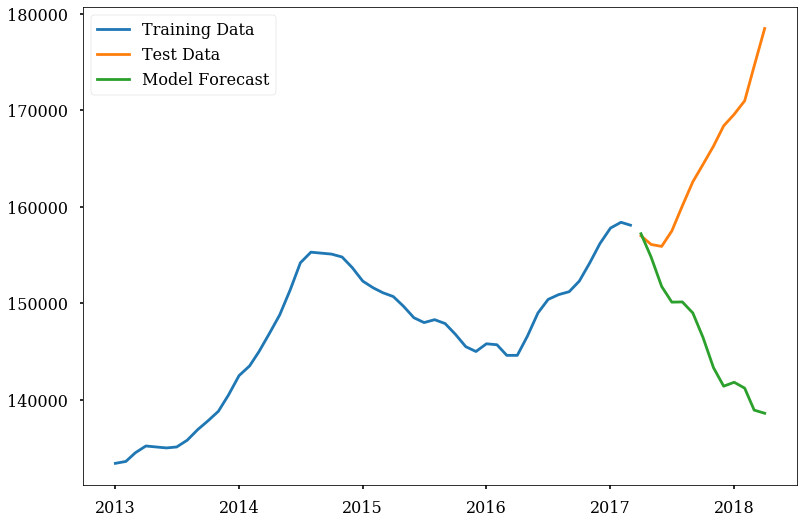

In [61]:
model = SARIMAX(ts_train, enforce_invertibility=False,enforce_stationarity=False,**best_params)
output = model.fit()
display(output.summary())
pred_dict = get_preds(output,ts_train,ts_test,True)
# output.aic

In [62]:
ts_test

date
2017-04-01    157000.0
2017-05-01    156100.0
2017-06-01    155900.0
2017-07-01    157500.0
2017-08-01    160100.0
2017-09-01    162600.0
2017-10-01    164400.0
2017-11-01    166300.0
2017-12-01    168400.0
2018-01-01    169600.0
2018-02-01    171000.0
2018-03-01    174600.0
2018-04-01    178500.0
Name: MeanValue, dtype: float64

,r2,rmse,Thiel's U
train,-13.077062,26906.001786,15.530798
test,-8.842934,22295.495879,10.297874


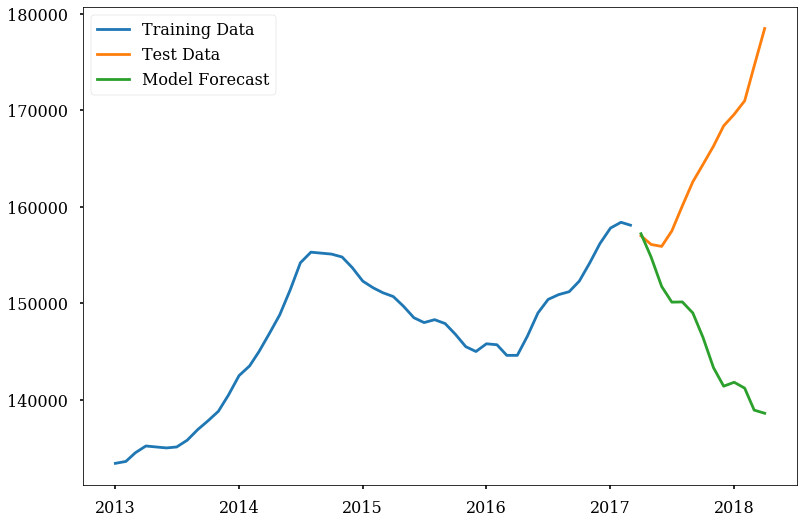

In [63]:
preds_res = get_preds(output,ts_train,ts_test)
# preds_res

In [ ]:
# plt.plot(ts_train,label='Training Data')
# plt.plot(ts_test,label='Test Data')
# plt.plot(y_hat_test,label='Model Forecast')
# plt.legend()

In [ ]:
fig,ax =plt.subplots(nrows=2)
ts_train.plot(color='black',lw=4,label='Raw Data',ax=ax[0])
# fig=ax.get_figure()


# axr=ax.twinx()

ax[0].set(ylabel='Raw Median Price')
ax[1].set(ylabel='Price Fluctuation Post Diff')
for i in [0,1,2,4,6,12]:#range(1,13,2):
    ts_train.diff(i).plot(label=f'Diff {i}',ax=ax[1])
    [a.legend() for a in fig.get_axes()]
    


In [ ]:
import pmdarima as pm

grid_model = pm.arima.AutoARIMA(seasonal=True,m=12,stationary=False,trace=True,
                               stepwise=False)
output = grid_model.fit(ts_train)
display(grid_model.summary())

output

# Step 6: Interpreting Results

In [ ]:
output.predict()